In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import neighbors, model_selection, metrics
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler

In [2]:
data_folder = "data/traces/"

def read_date(date: str):
    """Aggregate data of a single from parts"""
    data = pd.DataFrame()

    for i in range(50):
        try:
            frame = pd.read_csv(data_folder + date + "-{}.csv".format(i))
            data = pd.concat([data, frame], axis=0)
        except OSError:
            pass

    return data


def read_date_part(date_part: str):
    """Read data of a part of a capture date"""
    data = pd.DataFrame()

    try:
        frame = pd.read_csv(data_folder + date_part + ".csv")
        data = pd.concat([data, frame], axis=0)
    except OSError:
        pass

    return data

data = read_date_part("16-09-23")
data.set_index("timestamp")
print(data)

        packet_id            timestamp  packet_size            eth_src  \
0               0  1474552802257569024           70  18:b7:9e:02:20:44   
1               1  1474552802257692160           66  18:b7:9e:02:20:44   
2               2  1474552802323085056           66  14:cc:20:51:33:ea   
3               3  1474552802383173888           60  d0:52:a8:00:67:5e   
4               5  1474552802447910912           88  70:ee:50:18:34:43   
...           ...                  ...          ...                ...   
902933     947067  1474639199059330816           54  14:cc:20:51:33:ea   
902934     947068  1474639199620186112           60  00:24:e4:11:18:a8   
902935     947069  1474639199620225024           42  14:cc:20:51:33:ea   
902936     947070  1474639199771064064          156  30:8c:fb:2f:e4:b2   
902937     947071  1474639199986316032           66  14:cc:20:51:33:ea   

                               device_name protocol    iot  
0                            Triby Speaker      Ra

In [3]:
def attach_window_id(timestamped_frame: pd.DataFrame) -> list[pd.DataFrame]:
    """Slice the dataframe into 1-second intervals"""
    first_packet_time = timestamped_frame.iloc[0]['timestamp']
    last_packet_time = timestamped_frame.iloc[-1]['timestamp']
    windowed_frame = timestamped_frame.set_index('timestamp', drop=False) 

    ns_in_sec = int(1e9)
    number_of_windows = int((last_packet_time - first_packet_time) / ns_in_sec) + 1

    try:
        windowed_frame.insert(0, value=0, column="window_id")
    except Exception as e:
        print("It seems like the column 'window_id' already exists. Just updating values...")
        print(e)
    finally:
        windowed_frame.window_id.astype(np.int64)

    for window_id in range(0, number_of_windows):
        from_time = first_packet_time + window_id * ns_in_sec
        to_time = first_packet_time + (window_id  + 1) * ns_in_sec
        windowed_frame.loc[from_time:to_time, 'window_id'] = window_id
    
    windowed_frame.set_index('window_id', inplace=True)
    return windowed_frame


devices = pd.read_csv("data/list_of_devices.csv")
windowed_frame = attach_window_id(data)
print(windowed_frame)

           packet_id            timestamp  packet_size            eth_src  \
window_id                                                                   
0                  0  1474552802257569024           70  18:b7:9e:02:20:44   
0                  1  1474552802257692160           66  18:b7:9e:02:20:44   
0                  2  1474552802323085056           66  14:cc:20:51:33:ea   
0                  3  1474552802383173888           60  d0:52:a8:00:67:5e   
0                  5  1474552802447910912           88  70:ee:50:18:34:43   
...              ...                  ...          ...                ...   
86396         947067  1474639199059330816           54  14:cc:20:51:33:ea   
86397         947068  1474639199620186112           60  00:24:e4:11:18:a8   
86397         947069  1474639199620225024           42  14:cc:20:51:33:ea   
86397         947070  1474639199771064064          156  30:8c:fb:2f:e4:b2   
86397         947071  1474639199986316032           66  14:cc:20:51:33:ea   

In [4]:
def generate_features_labeled(windowed_frame: pd.DataFrame, device_frame: pd.DataFrame):
    """Calculate the mode, mean, and median of a window"""
    features = pd.DataFrame()

    for device_index in device_frame.index:
        device = device_frame.iloc[device_index]
        device_packets = windowed_frame.loc[windowed_frame['eth_src'] == device['eth_src']]
        device_features = generate_features(device_packets)

        device_features.insert(len(device_features.columns), "device_name", device['device_name'])
        device_features.insert(len(device_features.columns), "iot", device['iot'])

        features = pd.concat([features, device_features])

    features.columns = ["mean", "std", "n_bytes", "device_name", "iot"]
    return features

def generate_features(windowed_frame: pd.DataFrame):
    window_groups = windowed_frame.groupby(["window_id"])

    mean = window_groups['packet_size'].mean()
    std = window_groups['packet_size'].std()
    n_bytes = window_groups['packet_size'].sum()

    # TODO Not sure if fillna is a good idea
    return pd.concat([mean, std, n_bytes], axis=1).fillna(0)

def get_devices_in_window(windowed_frame: pd.DataFrame):
    devices_in_window = pd.DataFrame()
    
    for window_id in windowed_frame.index.unique():
        devices = windowed_frame.loc[window_id]['device_name']
        # iot = windowed_frame.loc[window_id]['iot']

        if not isinstance(devices, str):
            devices = devices.unique() 
            
        devices_in_window = pd.concat([devices_in_window, pd.DataFrame({"window_id": window_id, "devices": devices})])

    return devices_in_window

labeled_features = generate_features_labeled(windowed_frame, devices)
print(labeled_features)

                mean        std  n_bytes                         device_name  \
window_id                                                                      
0          60.000000   0.000000       60                        Smart Things   
1          99.500000  55.861436      199                        Smart Things   
11         60.000000   0.000000       60                        Smart Things   
16         60.000000   0.000000       60                        Smart Things   
21         60.000000   0.000000       60                        Smart Things   
...              ...        ...      ...                                 ...   
86393      82.666667  51.081634      248  TPLink Router Bridge LAN (Gateway)   
86394      66.000000   0.000000      132  TPLink Router Bridge LAN (Gateway)   
86395      42.000000   0.000000       42  TPLink Router Bridge LAN (Gateway)   
86396      71.666667  21.079216      215  TPLink Router Bridge LAN (Gateway)   
86397      54.000000  16.970563      108

In [5]:
def _balance_over_under(X, y, rus=False, random_state: int | None = None):
    oversampling = SMOTE(random_state=random_state)

    # Resource [32] is actually really old (2009), NearMiss is a better alternative than RUS
    # but I left it as an option
    if rus:
        undersampling = RandomUnderSampler(random_state=random_state)
    else:
        undersampling = NearMiss()

    # first oversample, then undersample
    X, y = oversampling.fit_resample(X, y)
    X, y = undersampling.fit_resample(X, y)

    return X, y

In [7]:
labeled_features.iloc[:, 0:3]

,mean,std,n_bytes
window_id,,,
0,60.000000,0.000000,60
1,99.500000,55.861436,199
11,60.000000,0.000000,60
16,60.000000,0.000000,60
21,60.000000,0.000000,60
...,...,...,...
86393,82.666667,51.081634,248
86394,66.000000,0.000000,132
86395,42.000000,0.000000,42


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import svm, neighbors, tree, ensemble, model_selection, metrics
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler

In [10]:
X = labeled_features.iloc[:, 0:3]
y = labeled_features.iloc[:]['device_name']
oversampling = SMOTE(random_state=20)
X, y = _balance_over_under(X, y, random_state=20)

In [11]:
model = neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance")
model.fit(X, y)

KNeighborsClassifier(weights='distance')

In [16]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Calculating the confidence of classification with noise

We calculate the confidence of a classifier with a dataset having only one device, with some artificial noise added to see how the classifier performance degrades with interference from sporadic network activity caused by other devices in the network.

In [12]:
data = read_date_part("echo0")
data.set_index("timestamp")
devices = pd.read_csv("scripts/list_of_devices.csv")
windowed_frame = attach_window_id(data)
labeled_features = generate_features_labeled(windowed_frame, devices)


       packet_id            timestamp  packet_size            eth_src  \
0             37  1474552806473253120          201  44:65:0d:56:cc:d3   
1            257  1474552808606093056          191  44:65:0d:56:cc:d3   
2            307  1474552820901074944           95  14:cc:20:51:33:ea   
3            308  1474552820911664128           54  44:65:0d:56:cc:d3   
4            309  1474552820911777024           95  44:65:0d:56:cc:d3   
...          ...                  ...          ...                ...   
52609     946979  1474639185847243008          191  44:65:0d:56:cc:d3   
52610     947063  1474639198804939008           95  14:cc:20:51:33:ea   
52611     947064  1474639198815504128           54  44:65:0d:56:cc:d3   
52612     947065  1474639198815619840           95  44:65:0d:56:cc:d3   
52613     947067  1474639199059330816           54  14:cc:20:51:33:ea   

                              device_name protocol    iot  
0                             Amazon Echo      Raw   True  
1  

In [47]:
ctr = 0
confidence = np.zeros(22)
confidence_progress = []
for i in range(len(labeled_features)):
#     print(model.predict(labeled_features.iloc[i, 0:3].to_numpy().reshape(1, -1)))
#     print(model.predict_proba(labeled_features.iloc[i, 0:3].to_numpy().reshape(1, -1)))
    if i % 500 == 0:
        confidence_progress.append(confidence)
    confidence = confidence + model.predict_proba(labeled_features.iloc[i, 0:3].to_numpy().reshape(1, -1))
    if(model.predict(labeled_features.iloc[i, 0:3].to_numpy().reshape(1, -1))) == "Amazon Echo":
        ctr += 1

In [54]:
confidence = [(i / confidence.sum()) * 100 for i in confidence[0]]

This is the sum of confidence values for all the predictions that the model makes, as this is a pure dataset, it makes sense for the confidence of classification to be this large a value.

<BarContainer object of 22 artists>

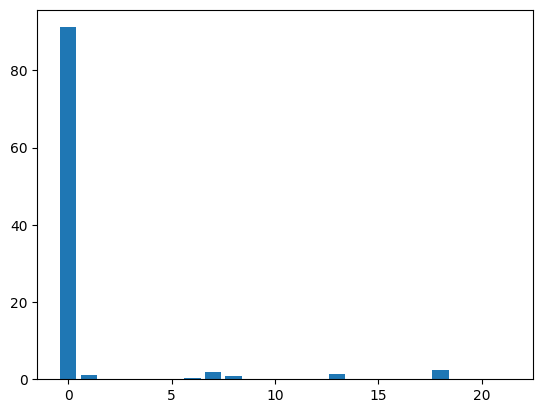

In [59]:
plt.bar([*range(len(confidence))], confidence)

Note: This takes a lot of time

In [61]:
accuracies = []
conf = []
for i in range(10):
    data = read_date_part("echo" + str(i * 20))
    data.set_index("timestamp")
    windowed_frame = attach_window_id(data)
    labeled_features = generate_features_labeled(windowed_frame, devices)
    ctr = 0
    arr = np.zeros(22)
    for j in range(len(labeled_features)):
#     print(model.predict(labeled_features.iloc[i, 0:3].to_numpy().reshape(1, -1)))
#     print(model.predict_proba(labeled_features.iloc[i, 0:3].to_numpy().reshape(1, -1)))
        arr = arr + model.predict_proba(labeled_features.iloc[j, 0:3].to_numpy().reshape(1, -1))
        if(model.predict(labeled_features.iloc[j, 0:3].to_numpy().reshape(1, -1))) == "Amazon Echo":
            ctr += 1
    print(f"accuracy of {i * 20}% noise is: {ctr/len(labeled_features)}")
    accuracies.append(ctr/len(labeled_features))
    conf.append(arr)

accuracy of 0% noise is: 0.9115353816327391
accuracy of 20% noise is: 0.8043001176807354
accuracy of 40% noise is: 0.7276234361186272
accuracy of 60% noise is: 0.6818150280996322
accuracy of 80% noise is: 0.6480856201526592
accuracy of 100% noise is: 0.6217611802674043
accuracy of 120% noise is: 0.5939569606174483
accuracy of 140% noise is: 0.5777446597118728
accuracy of 160% noise is: 0.5594332501016201
accuracy of 180% noise is: 0.5446043165467626


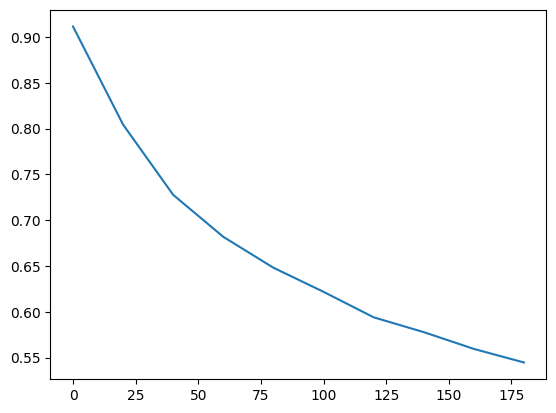

In [63]:
plt.plot([i * 20 for i in range(10)], accuracies)

<BarContainer object of 22 artists>

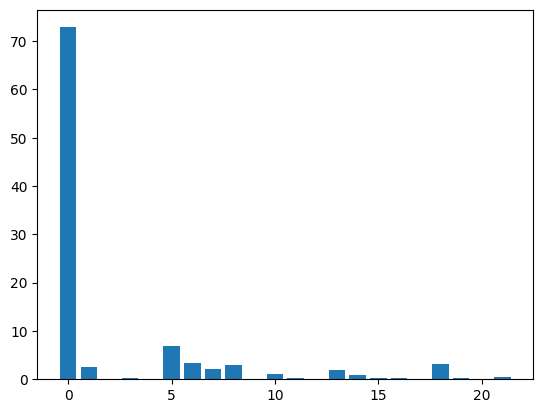

In [76]:
temp = [i / conf[2].sum() * 100 for i in conf[2][0]]
plt.bar([*range(len(confidence))], temp)

<BarContainer object of 22 artists>

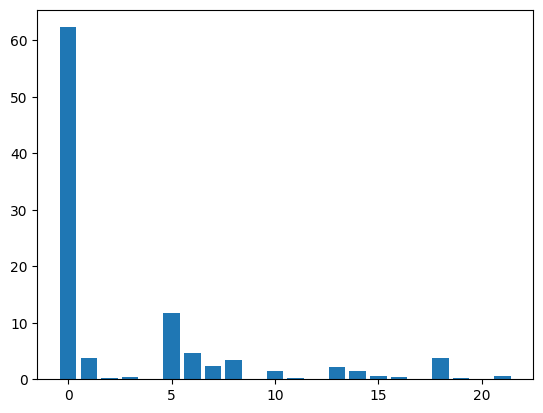

In [75]:
temp = [i / conf[5].sum() * 100 for i in conf[5][0]]
plt.bar([*range(len(confidence))], temp)

<BarContainer object of 22 artists>

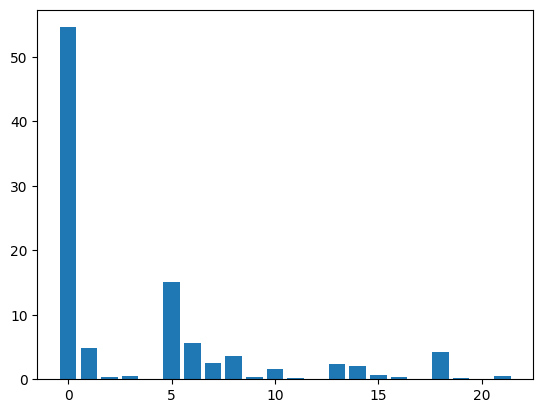

In [73]:
temp = [i / conf[9].sum() * 100 for i in conf[9][0]]
plt.bar([*range(len(confidence))], temp)

Although this is an artificial test and does not resemble a real world scenario, it is helpful to see how performance of the classifier would degrade with the amount of other devices that it may have to monitor. Although not included we also see a more chaotic distribution of confidence values outputted by the model.

## Classifying performance over time spent monitoring the network
In this part we will look at how the confidence for classifying a device in an aritificially noisy network changes with time spent listening to the connection.

In [64]:
data = read_date_part("echo60")
data.set_index("timestamp")
windowed_frame = attach_window_id(data)
labeled_features = generate_features_labeled(windowed_frame, devices)

In [77]:
len(labeled_features)

43239

In [79]:
conf_arr = []
conf = np.zeros(22)
for i in range(len(labeled_features)):
    conf = conf + model.predict_proba(labeled_features.iloc[i, 0:3].to_numpy().reshape(1, -1))
    if i % 1000 == 0:
        conf_arr.append(conf)

In [81]:
conf_arr[1]

array([[4.57723662e+02, 1.81591783e+00, 2.00000000e+00, 0.00000000e+00,
        1.36538292e+00, 0.00000000e+00, 4.09000000e+02, 4.31224120e+00,
        4.32432760e+00, 0.00000000e+00, 2.38640361e-01, 1.40000000e+01,
        0.00000000e+00, 6.14435010e+00, 5.61384137e-01, 8.70000000e+01,
        0.00000000e+00, 0.00000000e+00, 1.25140938e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

<BarContainer object of 22 artists>

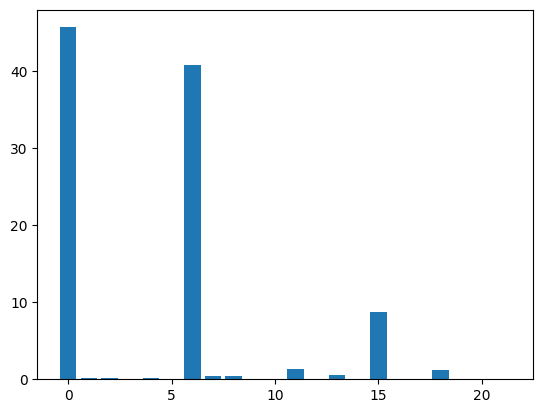

In [83]:
temp = [i / conf_arr[1].sum() * 100 for i in conf_arr[1][0]]
plt.bar([*range(len(confidence))], temp)

<BarContainer object of 22 artists>

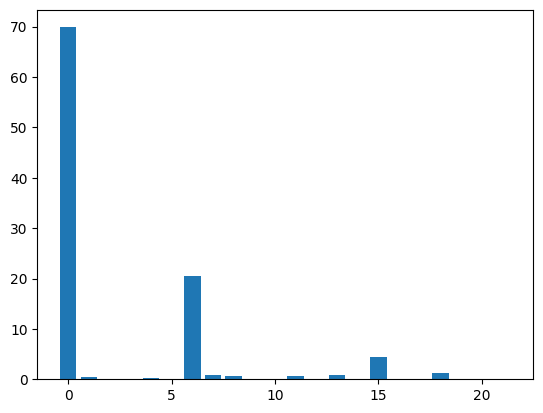

In [97]:
temp = [i / conf_arr[2].sum() * 100 for i in conf_arr[2][0]]
plt.bar([*range(len(confidence))], temp)

<BarContainer object of 22 artists>

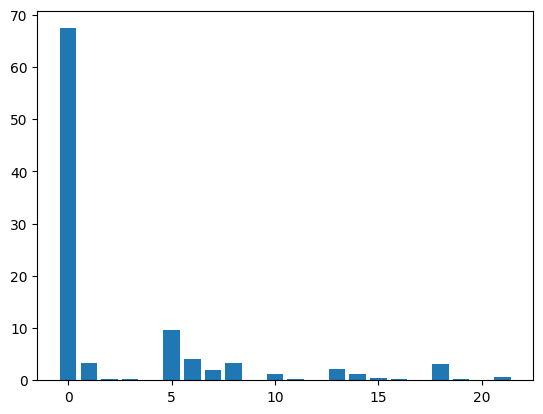

In [95]:
temp = [i / conf_arr[40].sum() * 100 for i in conf_arr[40][0]]
plt.bar([*range(len(confidence))], temp)

We can a major improvement over the first 1000-2000 samples, and a peak around midway before settling in around the confidence we see at the end

In [113]:
model.classes_

array(['Amazon Echo', 'Android Phone', 'Belkin Wemo switch',
       'Belkin wemo motion sensor', 'Blipcare Blood Pressure meter',
       'Dropcam', 'HP Printer', 'IPhone', 'Laptop',
       'NEST Protect smoke alarm', 'Netatmo Welcome',
       'Netatmo weather station', 'PIX-STAR Photo-frame',
       'Samsung Galaxy Tab', 'Samsung SmartCam', 'Smart Things',
       'TP-Link Day Night Cloud camera', 'TP-Link Smart plug',
       'TPLink Router Bridge LAN (Gateway)', 'Triby Speaker',
       'Withings Smart Baby Monitor', 'Withings Smart scale'],
      dtype=object)

## Performance with padding
We will take our original amazon echo dataset, and apply padding rules to see how the classifier performs.

In [114]:
data = read_date_part("echopad100")
data.set_index("timestamp")
windowed_frame = attach_window_id(data)
labeled_features = generate_features_labeled(windowed_frame, devices)

In [118]:
ctr = 0
for i in range(len(labeled_features)):
    if(model.predict(labeled_features.iloc[i, 0:3].to_numpy().reshape(1, -1))) == "Amazon Echo":
        ctr += 1

In [119]:
print(ctr/len(labeled_features))

0.001503517156204693


## Checking real life scenario (Multiple devices)